# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score, pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.losses = []

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        comp1 = 0
        for i in range(len(y)):
            comp1 += np.log(1 + np.exp((-(np.dot(weights[1:], x[i][1:]) + weights[0])) * y[i]))
        comp2 = np.linalg.norm(weights)**2 / (2 * self.C)
        return comp1/len(y) + comp2
                            
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-(X @ weights)))   
    
    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        for j in range(self.max_iter):
            comp1 = 0
            for i in range(len(y)):
                comp1 += y[i] * X_ext[i] * (1 - (1 / (1 + np.exp((0 - (np.dot(X_ext[i], self.weights_))) * y[i]))))  
            comp2 = self.weights_ / self.C
            delta = -(comp1/len(y) - comp2)
            saved_weights = list(self.weights_.copy())
            self.weights_ -= self.eta * delta
            self.losses.append(self.get_loss(X_ext, self.weights_, y))
            
            if np.linalg.norm(self.weights_ - saved_weights) < self.tol:
                break
            
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) > 0.5, 1, -1)
        

In [5]:
from sklearn import datasets
from sklearn import metrics

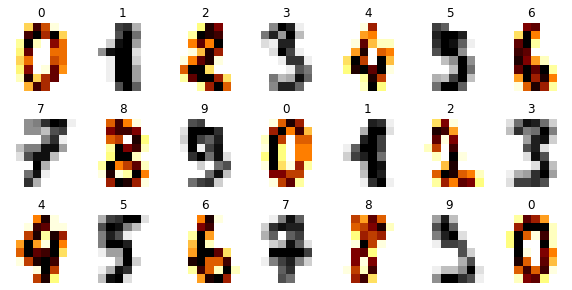

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test, show_plt=True):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    if show_plt:
        plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1]))

array([0.58661758, 0.40131234])

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


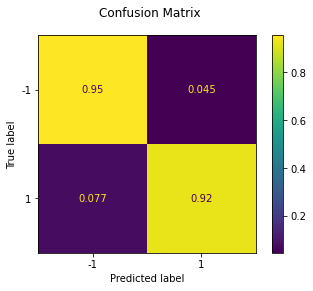

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

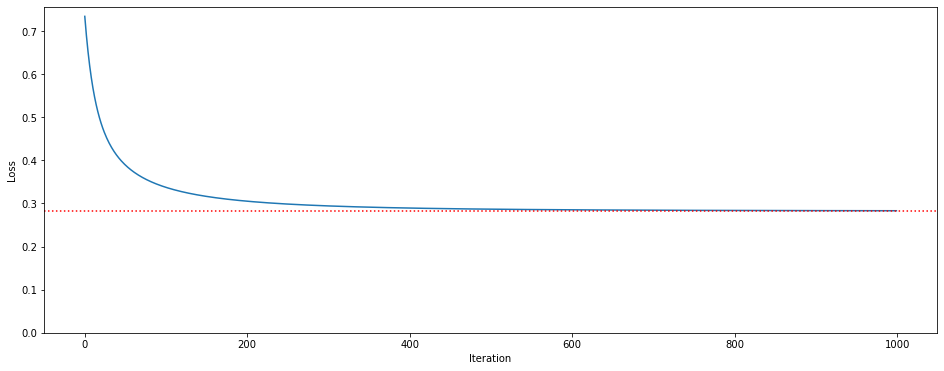

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(model.losses);
plt.xlabel("Iteration");
plt.ylabel("Loss");
min_y = np.min(model.losses)
plt.axhline(y=np.min(model.losses), color='r', linestyle=':')
plt.ylim(bottom=0)
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

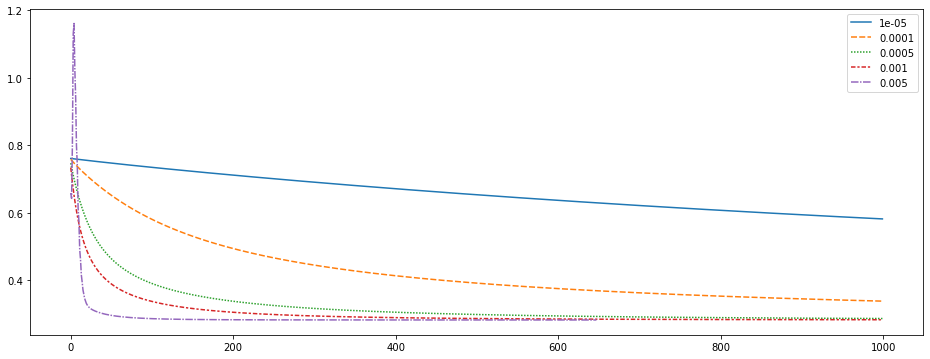

In [19]:
models_lr = pd.DataFrame() 
for learning_rate in [0.00001, 0.0005, 0.0001, 0.005, 0.001]:
    model = CustomLogisticRegression(eta=learning_rate)
    model.fit(X_train, y_train)
    model.losses += [np.nan] * (1000 - len(model.losses))
    models_lr[learning_rate] = model.losses
plt.figure(figsize=(16, 6));
sns.lineplot(data=models_lr);

Optimal learning rate approximates us to lesser loss in a curved manner. Very low rate (such as 0.00001) results in high marginal loss, while very high rate (such as 0.005) leads to loss peaks.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

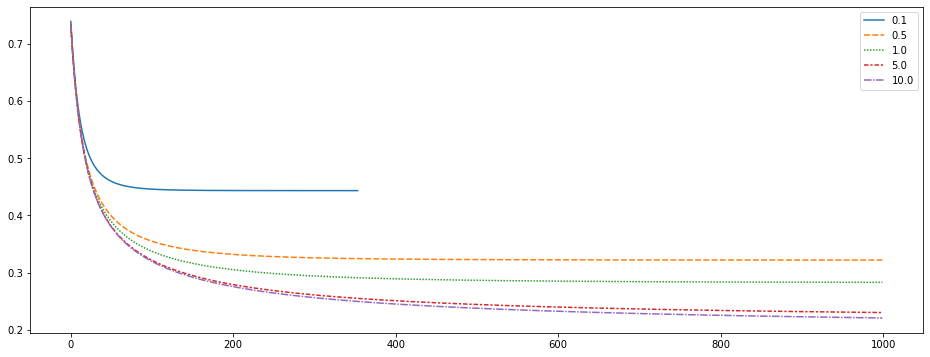

In [20]:
models_C = pd.DataFrame()
for C in [0.1, 0.5, 1, 5, 10]:
    model = CustomLogisticRegression(C=C)
    model.fit(X_train, y_train)
    model.losses += [np.nan] * (1000 - len(model.losses))
    models_C[C] = model.losses
plt.figure(figsize=(16, 6));
sns.lineplot(data=models_C);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


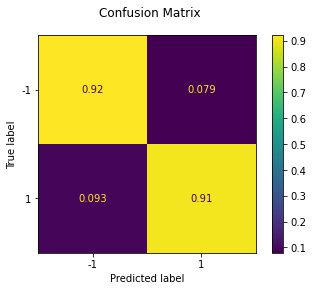

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


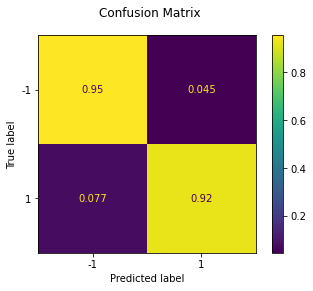

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


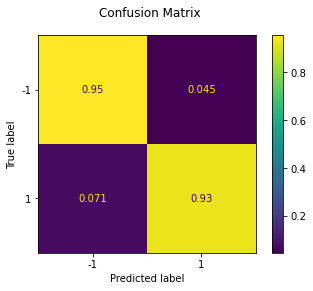

In [21]:
for C in [0.1, 1, 10]:
    model = CustomLogisticRegression(C=C)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

Higher C means that we consider our train data reliable and apply LESS penalty. This may improve the model quiality but it's performance out of our training scope may be more questionable (i.e. it may become less reliable).

**(0.5 points)** Compare zero initialization and random initialization. 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


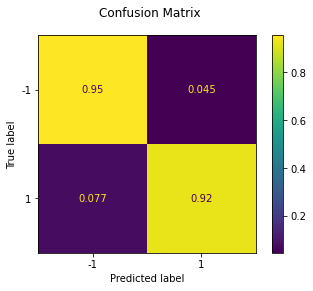

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


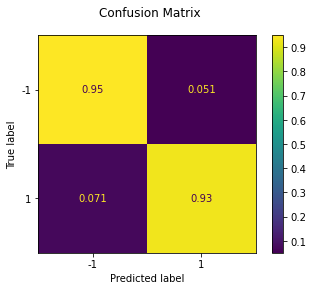

In [22]:
for zero_init in [False, True]:
    model = CustomLogisticRegression(zero_init=zero_init)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

Different initializing weights may lead to slightly different results (probably equivalent?), but in case of logistic regression starting values do not seem critical choice at all. 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [23]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return pairwise_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        cl_weights = []
        for cl in self.classes_:
            cl_weights.append(sum([weights[i] for i in range(len(y)) if y[i] == cl]))
        return cl_weights
    
            
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            n_points_distances = np.sort(P, axis=1)[:, 0:self.n_neighbors]
            sorted_points_indexes = P.argsort(axis=1)
            n_points_indexes = sorted_points_indexes[:, 0:self.n_neighbors]
            n_points_labels = self.y[n_points_indexes]
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / np.maximum(n_points_distances, self.eps)
            cl_weights = np.array([self.get_class_weights(n_points_labels[i], weights_of_points[i]) for i in range(len(weights_of_points))])  
            #return cl_weights / sum(cl_weights)
            return cl_weights / np.sum(cl_weights, axis=1)[:, np.newaxis]
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis=1)

In [24]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [25]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [26]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

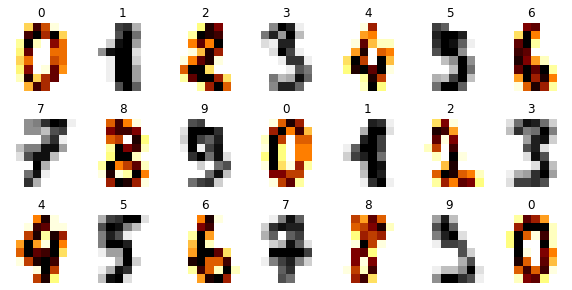

In [27]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [28]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [29]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


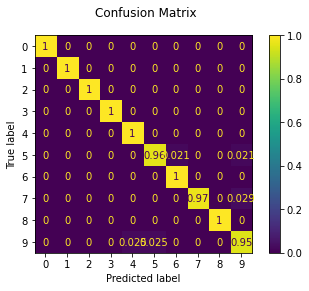

In [30]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [31]:
assert train_acc == 1.0
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Most difficulties are seen when distinguishing (5 -> 6, 9) and (9 -> 4, 5). This may be axplained by similarities in handwriting patterns of these numbers.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

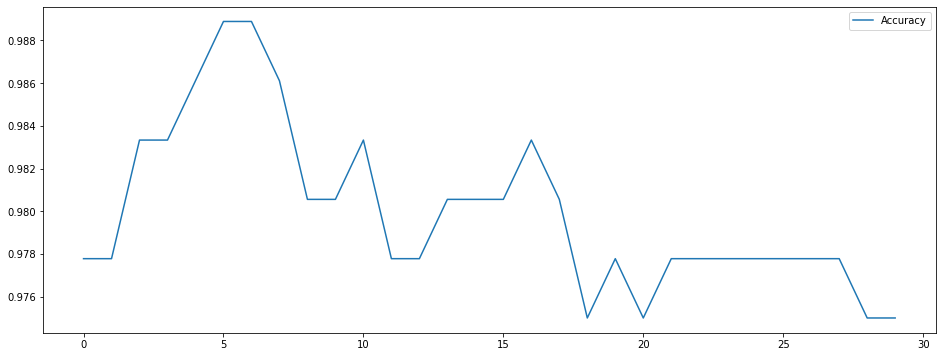

In [32]:
accuracy = []
models_N = pd.DataFrame()
for N in range(1, 31):
    model = CustomKNeighborsClassifier(n_neighbors=N, weights='distance')
    model.fit(X_train, y_train)
    accuracy.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
models_N["Accuracy"] = accuracy
plt.figure(figsize=(16, 6));
sns.lineplot(data=models_N);

K-values must be chosen empirically (which is one of the flaws of the model). Here we can see that a value of n=6 is optimal. The only way to make sure of that is to iterate through all K's. A middle point of square N may be a good start

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


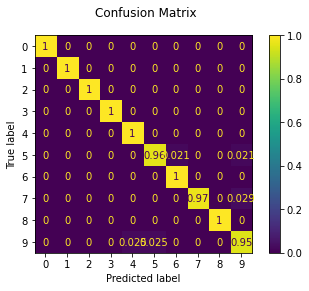

Weights: distance. Train accuracy = 1.0, test accuracy = 0.9861111111111112


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


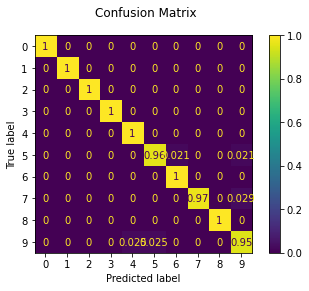

Weights: uniform. Train accuracy = 0.9895615866388309, test accuracy = 0.9861111111111112


In [33]:
for weigths in ["distance", "uniform"]:
    model = CustomKNeighborsClassifier(n_neighbors=5, weights=weigths)
    model.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(f"Weights: {weigths}. Train accuracy = {train_acc}, test accuracy = {test_acc}")

No differences in test accuracies noted.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

The taxicab metric (also known as L1 distance, city block distance, Manhattan distance) is most usually mentioned in literature

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Manhattan distance is recommended to use when distances are large and data is massive. Coagulation panel lab values (D-dimers, protrombine time, fibrinogen) vary a great deal and a huge set of data required to make a model predicting lung emboli.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [34]:
PATH = "./data/"

In [35]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [36]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

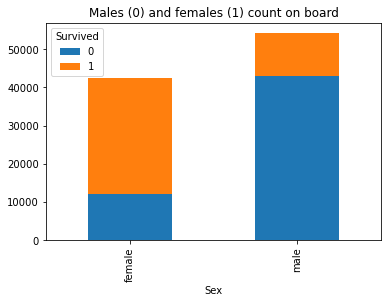

In [37]:
data.groupby(["Sex", "Survived"]).count()["Age"].unstack().plot.bar(stacked=True).set(title="Males (0) and females (1) count on board");

There were less females on board, but their chances of survival were significantly higher, so it seems that the "women" part of the "Women and children first" rule applies to our dataset.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(x="Age", hue="Survived", data=data).set(title="Age distribution");

In [ ]:
plot = sns.FacetGrid(data, col="Survived", height=6);
plot.map(sns.histplot, "Age", bins=20, kde=True);
plot.fig.subplots_adjust(top=0.9);
plot.fig.suptitle("Age distribution by survival");

In [ ]:
print(f'Mean age of survivors: {round(data.loc[data["Survived"] == 0, "Age"].mean(), 2)}')
print(f'Mean age of deceased: {round(data.loc[data["Survived"] == 1, "Age"].mean(), 2)}')
print(f'Median age of survivors: {round(data.loc[data["Survived"] == 0, "Age"].median(), 2)}')
print(f'Median age of deceased: {round(data.loc[data["Survived"] == 1, "Age"].median(), 2)}')

Both mean and median age of survivors is larger. This may very well be due to larger mean/median age of passengers who had class 1 and 2 tickets which were associated with better survival.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x="Pclass", hue="Survived", data=data, palette="Set1").set(title="Survivors and deceased by ticket class");

The total number of passengers from classes 1 and 2 is lower than that of class 3. More than half of passengers from classes 1 and 2 survived while only a quarter or so survived from class 3. We know that passengers with class 3 tickets were located at lower decks and thus had less chances to make it to the lifeboats.<br><br>
We may assume that there is a correlation between person's age and ticket class. Let's investigate that.

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x="Pclass", y="Age", data=data).set(title="Age distribution by ticket class");

Indeed, mean age of passengers progressively increases with their tickets class (3 -> 1). Our best guess is that older people are generally more well-off and may afford a better cabin.

Some correlation with [Embarked] would not be surprising, since passengers from one city (port) may be generally more well-off than passengers from some other city.

In [ ]:
pclass_emb_distr = (data.groupby(by=["Pclass", "Embarked"]).count()/data.groupby(by=["Pclass"]).count()*100).iloc[:, 0].reset_index()
pclass_emb_distr["Pclass"] = pclass_emb_distr["Pclass"].astype(str)
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.countplot(x="Pclass", hue="Embarked", data=data, palette="Set2", ax=ax[0]).set(title="Passengers count by embarkation port");
sns.lineplot(x="Pclass", y="Age", hue="Embarked", data=pclass_emb_distr, ax=ax[1]).set(title="Survivors share by embarkation port");
ax[1].set(ylabel="share for a given Pclass, %");

From the next chart we can see that [Embarked] may very well affect survival independently of ticket class (even though the pattern is the same among embarkation ports, survival rates differ significantly).

In [ ]:
sns.catplot(x="Pclass", y="Survived", col="Embarked", data=data, kind="point", color="red");

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [ ]:
missing_data = pd.DataFrame()
missing_data["missing"] = data.isnull().sum()[data.isnull().sum() > 0].sort_values(ascending=False)
missing_data["missing_percent"] = missing_data["missing"]/data.shape[0]*100
missing_data

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

#### Cabin

In [ ]:
data["Cabin"] = data["Cabin"].str[0]
test["Cabin"] = test["Cabin"].str[0]
data["Cabin"].value_counts()

In [ ]:
for df in [data, test]:
    df["Cabin"].fillna("X", inplace=True)

#### Ticket

In [ ]:
print(f'Unique values of [Ticket]: {round(len(data["Ticket"].unique())/len(data[data["Ticket"].notna()])*100, 2)}%')

In [ ]:
for df in [data, test]:
    df.drop(columns="Ticket", inplace=True)

#### Age

In [ ]:
for df in [data, test]:
    df.loc[(df.SibSp > 0) & (df.Parch > 0), "Relatives"] = "SibSp+ParCh"
    df.loc[(df.SibSp == 0) & (df.Parch > 0), "Relatives"] = "ParCh"
    df.loc[(df.SibSp > 0) & (df.Parch == 0), "Relatives"] = "SibSp"
    df.loc[(df.SibSp == 0) & (df.Parch == 0), "Relatives"] = "None"
    for Pclass in (1, 2, 3):
        df.loc[(df.Age.isna() & (df.SibSp > 0) & (df.Parch > 0) & (df.Pclass == Pclass)), "Age"] = df[(df.SibSp > 0) & (df.Parch > 0) & (df.Pclass == Pclass)]["Age"].mean()
        df.loc[(df.Age.isna() & (df.SibSp == 0) & (df.Parch > 0) & (df.Pclass == Pclass)), "Age"] = df[(df.SibSp == 0) & (df.Parch > 0) & (df.Pclass == Pclass)]["Age"].mean()
        df.loc[(df.Age.isna() & (df.SibSp > 0) & (df.Parch == 0) & (df.Pclass == Pclass)), "Age"] = df[(df.SibSp > 0) & (df.Parch == 0) & (df.Pclass == Pclass)]["Age"].mean()
        df.loc[(df.Age.isna() & (df.SibSp == 0) & (df.Parch == 0) & (df.Pclass == Pclass)), "Age"] = df[(df.SibSp == 0) & (df.Parch == 0) & (df.Pclass == Pclass)]["Age"].mean()
    df.drop(columns="Relatives", inplace=True)

#### Embarked

In [ ]:
for df in [data, test]:
    df["Embarked"].fillna("S", inplace=True)

#### Fare

In [ ]:
for df in [data, test]:
    df["Fare"].fillna(df["Fare"].median(), inplace=True)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
sex_map = {"male": 0, "female": 1}
cabin_map = {"X": 0, "C": 2, "B": 2, "A": 1, "D": 2, "E": 2, "F": 2, "G": 2, "T": 2}
embarked_map = {"S": 0, "C": 1, "Q": 2}

In [ ]:
X_train = data.copy()
X_train['Sex'] = X_train['Sex'].map(sex_map)
X_train['Cabin'] = X_train['Cabin'].map(cabin_map)
X_train['Embarked'] = X_train['Embarked'].map(embarked_map)
y_train = data["Survived"]

for df in [X_train, test]:
    df['Alone'] = ((df['SibSp'] + df['Parch']) == 0).astype(int)
    df.drop(['SibSp', 'Parch', 'Name'], axis=1, inplace=True)
X_train.drop('Survived', axis=1, inplace=True)

test['Sex'] = test['Sex'].map(sex_map)
test['Cabin'] = test['Cabin'].map(cabin_map)
test['Embarked'] = test['Embarked'].map(embarked_map)

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
"""from itertools import combinations
column_list = list(combinations(X_train.columns, X_train.shape[1] - 0))
knn_accuracy = []
st_scaler = StandardScaler()
for columns in column_list:
    for n in range(1, 26):
        knn = KNeighborsClassifier(n_neighbors=n)
        this_train = X_train[list(columns)].copy()
        print(f"Columns: {columns}, n={n}")
        scaled_knn = make_pipeline(StandardScaler(), knn)
        score = cross_val_score(scaled_knn, this_train, y_train, scoring='accuracy', cv=k_fold).mean()
        knn_accuracy.append((columns, score))
        if score > 0.771:
            print(score)"""

In [ ]:
"""for C in [0.0005, 0.001, 0.002, 0.005]:
    log_regr = LogisticRegression(C=C, max_iter=10000, random_state=42)
    st_scaler = StandardScaler()
    scaled_log_regr = make_pipeline(StandardScaler(), log_regr)
    print(f"c={C}")
    noscale_score = cross_val_score(log_regr, X_train, y_train, scoring='accuracy', cv=k_fold).mean()
    if noscale_score > 0.764:
        print(f"No scale: {noscale_score}")
    scaled_score = cross_val_score(scaled_log_regr, X_train, y_train, scoring='accuracy', cv=k_fold).mean()
    if scaled_score > 0.764:
        print(f"Scaled: {scaled_score}")"""

In [ ]:
"""k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

log_regr = LogisticRegression(C=0.05, max_iter=10000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=13)
st_scaler = StandardScaler()

accuracy = []

# Without feature scaling, original model
accuracy.append(cross_val_score(log_regr, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

#With scaling StandardScaler + LogisticRegression
scaled = make_pipeline(StandardScaler(), log_regr)
accuracy.append(cross_val_score(scaled, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

# Without feature scaling, original model
accuracy.append(cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

#With scaling StandardScaler + Knn

accuracy"""

In [ ]:
"""import random
for df in [data, test]:
    df1 = df.groupby(["Pclass", "Sex"])['Embarked'].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    df['Embarked'].fillna("X", inplace=True)

def embarked_zero(row):
    port_ = ['S','C','Q']
    if row.Embarked == "X": 
        return random.choices(port_, weights = df1[((df1["Sex"] == row["Sex"]) & (df1["Pclass"] == row["Pclass"]))]["percent"]/100)[0]
    else:
        return row.Embarked

for df in [data, test]:
    df['Embarked']=df.apply(lambda row: embarked_zero(row),axis=1)"""

In [ ]:
log_regr = LogisticRegression(C=0.0005, max_iter=10000, random_state=42)
st_scaler = StandardScaler()
scaled_log_regr = make_pipeline(StandardScaler(), log_regr)
accuracy_ns = cross_val_score(log_regr, X_train, y_train, scoring='accuracy', cv=k_fold).mean()
accuracy_sc = cross_val_score(scaled_log_regr, X_train, y_train, scoring='accuracy', cv=k_fold).mean()
print(f"Logit base: {accuracy_ns}")
print(f"Logit scaled: {accuracy_sc}")

In [ ]:
"""knn_columns = ['Pclass', 'Sex', 'Alone', 'Fare', 'Cabin', 'Embarked']
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
max_found = (0, 0)
for n in range(1, 251, 25):
    knn = KNeighborsClassifier(n_neighbors=n)
    st_scaler = StandardScaler()
    knn_scaled = make_pipeline(StandardScaler(), knn)
    base = cross_val_score(knn, X_train[knn_columns], y_train, scoring='accuracy', cv=k_fold).mean()
    scaled = cross_val_score(knn_scaled, X_train[knn_columns], y_train, scoring='accuracy', cv=k_fold).mean()
    if max(base, scaled) > max_found[1]:
        max_found = (n, max(base, scaled))
    print(f"N = {n}, current max = {max_found[1].round(4)} (from step {max_found[0]})")"""

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Best model we've managed to create is logistic regression with some feature engineering. Public kaggle score is **0.792**

In [ ]:
def make_submission(df, pred, n):
    '''
    Create submission file
    :param df: test dataframe
    :param pred: predictions
    :n: numner of the file
    :returns: submission file in the appropriate format
    '''
    submission = pd.DataFrame({
            "PassengerId": df["PassengerId"],
            "Survived": pred
        })

    submission.to_csv('submission_titanic_{}.csv'.format(n), index=False)

In [ ]:
log_regr = LogisticRegression(C=0.0005, max_iter=10000, random_state=42)
log_regr.fit(X_train, y_train)
y_pred_log_regr = log_regr.predict(test.iloc[:, 1:])
make_submission(test, y_pred_log_regr, '77')